In [1]:
import os
import vtk
import numpy as np
from vtk.util import numpy_support
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

TARGET_N = 100

def resample_array(arr, target_len):
    original_len = len(arr)
    x_old = np.linspace(0, 1, original_len)
    x_new = np.linspace(0, 1, target_len)
    f = interp1d(x_old, arr, kind='linear', axis=0, fill_value="extrapolate")
    return f(x_new)

def read_vtk_point_cell_data(filepath):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(filepath)
    reader.Update()
    polydata = reader.GetOutput()

    # 提取按连接顺序排列的坐标
    num_points = polydata.GetNumberOfPoints()
    num_lines = polydata.GetNumberOfLines()
    if num_lines != 1:
        raise ValueError(f"{filepath} contains {num_lines} lines (expected 1)")

    line = polydata.GetLines().GetData()
    line_np = numpy_support.vtk_to_numpy(line)
    line_point_ids = line_np[1:]
    coords = np.array([polydata.GetPoint(pid) for pid in line_point_ids])

    # 插值 coords
    resampled_coords = resample_array(coords, TARGET_N)

    # 插值 point data
    point_data = {}
    pd = polydata.GetPointData()
    for i in range(pd.GetNumberOfArrays()):
        array = pd.GetArray(i)
        if array:
            name = array.GetName()
            data = numpy_support.vtk_to_numpy(array)
            if len(data) == len(coords):  # 只处理与 coords 长度一致的
                resampled = resample_array(data, TARGET_N)
                point_data[name] = resampled.astype(data.dtype)
            else:
                point_data[name] = data  # 保留不变

    # 不处理 cell_data，直接保留原始数据
    cell_data = {}
    cd = polydata.GetCellData()
    for i in range(cd.GetNumberOfArrays()):
        array = cd.GetArray(i)
        if array:
            name = array.GetName()
            data = numpy_support.vtk_to_numpy(array)
            cell_data[name] = data

    return point_data, cell_data, resampled_coords

def batch_read_vtk_data(directory):
    results = {}
    for fname in os.listdir(directory):
        if fname.lower().endswith(".vtk"):
            full_path = os.path.join(directory, fname)
            point_data, cell_data, coords = read_vtk_point_cell_data(full_path)
            results[fname] = {
                'point_data': point_data,
                'cell_data': cell_data,
                'coords': coords
            }
    return results

# 用法示例
base_dir = r"D:\!BraVa_src\ica_results\vmtkgeometry_91"
vtk_data_dict = batch_read_vtk_data(base_dir)

all_coords = [vtk_data_dict[name]["coords"] for name in vtk_data_dict]
coords_array = np.stack([vtk_data_dict[name]["coords"] for name in vtk_data_dict], axis=0)
# 所有曲线平移，使起点对齐到 [0, 0, 0]
coords_array = coords_array - coords_array[:, 0:1, :]
# 广播减法，coords_array[:, 0:1, :] shape 为 [N_samples, 1, 3]

In [2]:
for fname, content in vtk_data_dict.items():
    point_attrs = content['point_data']
    cell_attrs = content['cell_data']
    coords = content['coords']

    print(f"{fname}:")
    print(f"  Point attributes ({len(point_attrs)}): {list(point_attrs.keys())}")
    print(f"  Cell attributes ({len(cell_attrs)}): {list(cell_attrs.keys())}")
    print(f"  Points (coords): {coords.shape[0]}")
    print("-" * 60)

# print(list(vtk_data_dict.keys()))
# 收集所有 length 数值
# all_lengths = []
# for fname, content in vtk_data_dict.items():
#     length = content['cell_data']['Length']  # 通常是一个数值或一维数组
#     # 如果是 array 取第一个元素
#     if isinstance(length, (list, np.ndarray)):
#         length = float(np.ravel(length)[0])
#     all_lengths.append(length)

# # 计算均值和方差
# mean_length = np.mean(all_lengths)
# var_length = np.var(all_lengths, ddof=1)  # ddof=1 得到样本方差

# print("Mean Length:", mean_length)
# print("Variance of Length:", var_length)

BG0001_L.vtk:
  Point attributes (5): ['Curvature', 'Torsion', 'FrenetTangent', 'FrenetNormal', 'FrenetBinormal']
  Cell attributes (2): ['Length', 'Tortuosity']
  Points (coords): 100
------------------------------------------------------------
BG0001_R.vtk:
  Point attributes (5): ['Curvature', 'Torsion', 'FrenetTangent', 'FrenetNormal', 'FrenetBinormal']
  Cell attributes (2): ['Length', 'Tortuosity']
  Points (coords): 100
------------------------------------------------------------
BG0003_L.vtk:
  Point attributes (5): ['Curvature', 'Torsion', 'FrenetTangent', 'FrenetNormal', 'FrenetBinormal']
  Cell attributes (2): ['Length', 'Tortuosity']
  Points (coords): 100
------------------------------------------------------------
BG0003_R.vtk:
  Point attributes (5): ['Curvature', 'Torsion', 'FrenetTangent', 'FrenetNormal', 'FrenetBinormal']
  Cell attributes (2): ['Length', 'Tortuosity']
  Points (coords): 100
------------------------------------------------------------
BG0004_L.vtk:
  

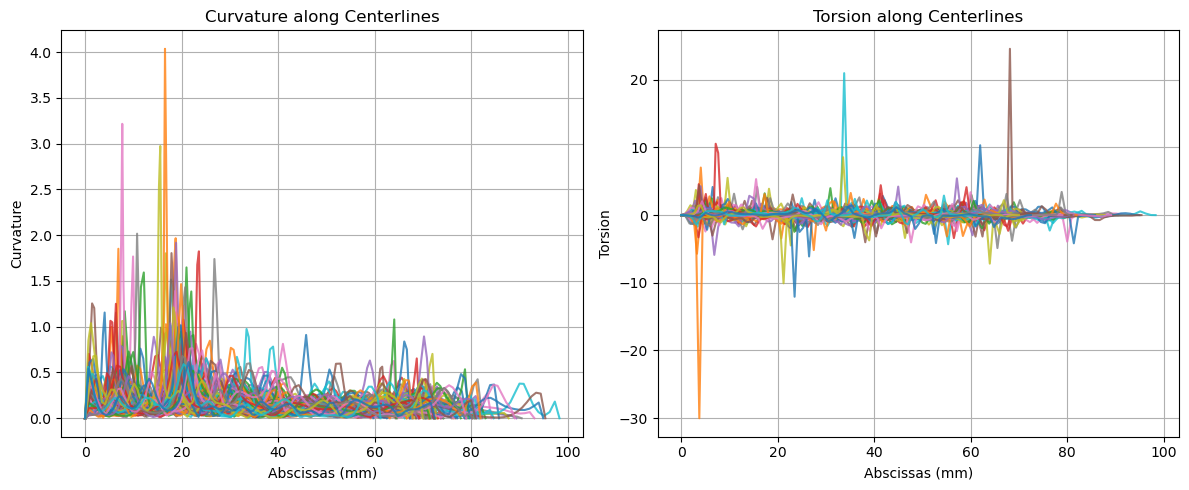

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# curvature subplot
plt.subplot(1, 2, 1)
for fname, content in vtk_data_dict.items():
    coords = content['coords']
    pdata = content['point_data']
    if 'Curvature' in pdata:
        diffs = np.linalg.norm(np.diff(coords, axis=0), axis=1)
        arc_length = np.concatenate([[0], np.cumsum(diffs)])
        plt.plot(arc_length, pdata['Curvature'], label=fname, alpha=0.8)
plt.title("Curvature along Centerlines")
plt.xlabel("Abscissas (mm)")
plt.ylabel("Curvature")
plt.grid(True)

# torsion subplot
plt.subplot(1, 2, 2)
for fname, content in vtk_data_dict.items():
    coords = content['coords']
    pdata = content['point_data']
    if 'Torsion' in pdata:
        diffs = np.linalg.norm(np.diff(coords, axis=0), axis=1)
        arc_length = np.concatenate([[0], np.cumsum(diffs)])
        plt.plot(arc_length, pdata['Torsion'], label=fname, alpha=0.8)
plt.title("Torsion along Centerlines")
plt.xlabel("Abscissas (mm)")
plt.ylabel("Torsion")
plt.grid(True)

plt.tight_layout()
plt.show()


In [4]:
from io import StringIO
import sys
import re
import csv

class OutputCatcher:
    def __init__(self):
        self._stdout = sys.stdout
        self.buffer = StringIO()

    def __enter__(self):
        sys.stdout = self.buffer
        return self

    def __exit__(self, *args):
        sys.stdout = self._stdout

    def get(self):
        return self.buffer.getvalue()

def parse_alignment_log(log_text):
    pattern_iter = re.compile(r"(updating step: r=|Iteration )(\d+)")
    pattern_residual = re.compile(r"Residual(?: Change)?: ([\d\.]+)")
    pattern_energy = re.compile(r"Residual Energy: ([\d\.]+)")

    results = {}
    current_iter = None

    for line in log_text.splitlines():
        iter_match = pattern_iter.search(line)
        if iter_match:
            current_iter = int(iter_match.group(2))
            if current_iter not in results:
                results[current_iter] = {'iter': current_iter}

        res_match = pattern_residual.search(line)
        if res_match and current_iter is not None:
            results[current_iter]['residual'] = float(res_match.group(1))

        ene_match = pattern_energy.search(line)
        if ene_match and current_iter is not None:
            results[current_iter]['energy'] = float(ene_match.group(1))

    # 转成列表并排序
    return [results[k] for k in sorted(results)]


def write_log_to_csv(results, filename):
    with open(filename, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["iter", "residual", "energy"])
        writer.writeheader()
        writer.writerows(results)
    print(f"[log] Wrote {len(results)} rows to {filename}")


[log] Wrote 20 rows to ./alignment_plain.csv
[log] Wrote 20 rows to ./alignment_weighted.csv
✅ 保存了 aligned_curvatures_weighted，shape=(100, 91)


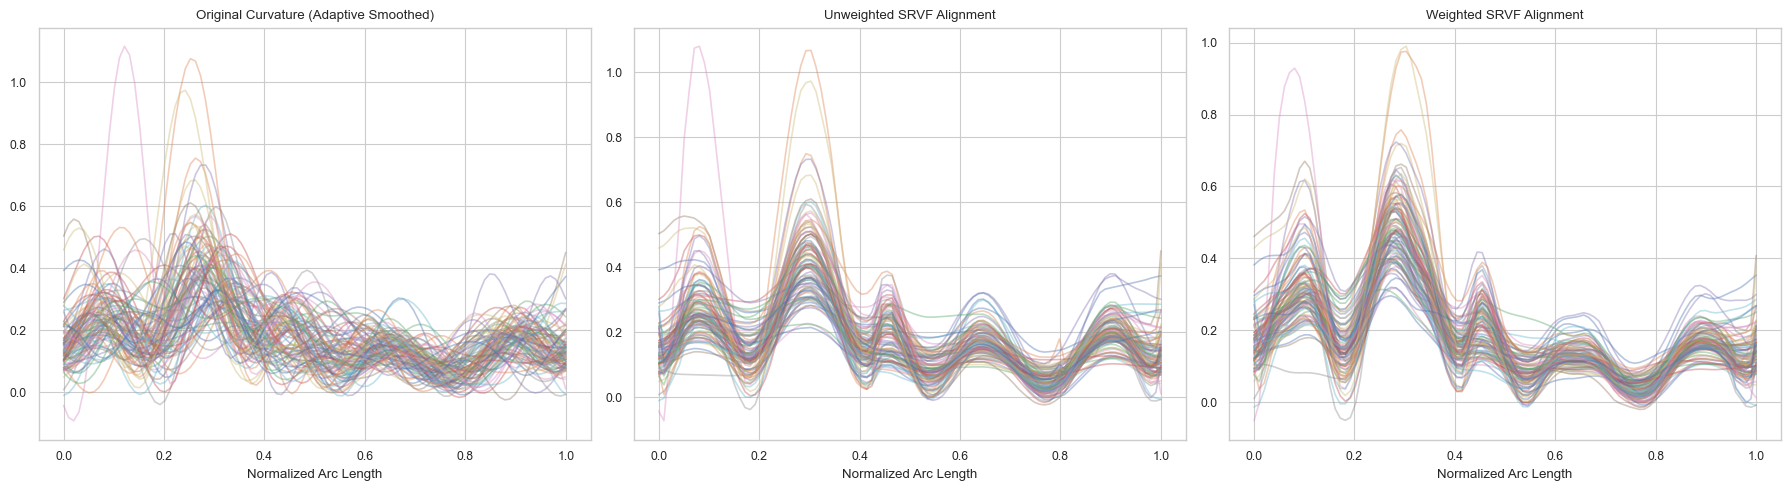

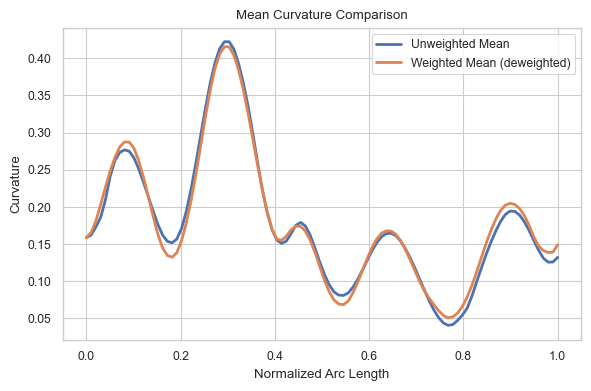

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft
from scipy.signal import find_peaks
from fdasrsf.utility_functions import resamplefunction
from fdasrsf.time_warping import fdawarp
import seaborn as sns

sns.set(style="whitegrid", context="paper", font_scale=1)
# 参数
# # target_len = 200
# target_len = 500  # 目标长度
t_resample = np.linspace(0, 1, TARGET_N )
alpha_s = 0.75

# Fourier 平滑函数
def fourier_lowpass(signal, keep_ratio):
    N = len(signal)
    fhat = fft(signal)
    keep = int(N * keep_ratio)
    fhat[keep:-keep] = 0
    return np.real(ifft(fhat))

# 自适应平滑函数：使平滑后曲线具有约 5 个峰
def adaptive_fourier_smoothing(signal, peak_target=5, tol=1, max_iter=50):
    ratios = np.linspace(0.01, 0.2, 100)
    for r in ratios:
        smoothed = fourier_lowpass(signal, keep_ratio=r)
        peaks, _ = find_peaks(smoothed,
                                prominence=(np.max(smoothed) - np.min(smoothed)) * 0.08,
                                distance=TARGET_N  // 10  # 避免过密峰值
                            )
        if abs(len(peaks) - peak_target) <= tol:
            return smoothed
    return fourier_lowpass(signal, keep_ratio=0.03)

# 结构权重函数（使用自适应傅立叶平滑）
def composite_weight(curves, alpha_s=0.75):
    """
    使用 adaptive Fourier smoothing 后的结构强度生成逐点加权权重。
    - curves: ndarray of shape [T, N]
    - alpha_s: 放大系数（越大越强调曲率突变区域）
    
    返回:
        weights: ndarray of shape [T, N]
    """
    T, N = curves.shape

    # Step 1: 对每条曲线使用 adaptive smoothing
    smoothed_curves = np.stack([
        adaptive_fourier_smoothing(curves[:, i], peak_target=5, tol=1)
        for i in range(N)
    ], axis=1)

    # Step 2: 局部结构强度（曲率绝对值）
    mag = np.abs(smoothed_curves)

    # Step 3: 一致性系数（强调 across-curves 一致的区域）
    consistency = 1.0 / (np.std(smoothed_curves, axis=1) + 1e-5)
    consistency = (consistency - consistency.min()) / (consistency.max() - consistency.min() + 1e-8)
    consistency = consistency[:, None]  # shape [T, 1]

    # Step 4: 综合权重计算
    weights = (1 + alpha_s * mag) * (0.5 + 0.5 * consistency)

    # Step 5: 全局归一化
    weights /= (weights.mean() + 1e-8)

    return weights  # shape [T, N]


# 主流程
names = list(vtk_data_dict.keys())
resampled_curves = []

for name in names:
    curvature = vtk_data_dict[name]["point_data"]["Curvature"]
    coords = vtk_data_dict[name]["coords"]

    # 不再重新插值，只保留 smoothing（输入已经是500点）
    curvature = adaptive_fourier_smoothing(curvature, peak_target=5, tol=1)
    resampled_curves.append(curvature)


f = np.stack(resampled_curves).T
time = t_resample
MaxItr = 20
# # 不加权对齐
with OutputCatcher() as capture_plain:
    obj_plain = fdawarp(f.copy(), time)
    obj_plain.srsf_align(parallel=True, MaxItr=MaxItr, verbose=True)

plain_log = capture_plain.get()
plain_results = parse_alignment_log(plain_log)
write_log_to_csv(plain_results, "./alignment_plain.csv")

# 加权对齐
W = composite_weight(f, alpha_s=alpha_s)
obj_weighted = fdawarp(f.copy(), time)
obj_weighted.custom_weights = W.mean(axis=0)  # 向自定义方法传权重
alpha_init = 0.05
# momentum_beta = 0.9
momentum_beta1= 0.9
momentum_beta2 = 0.999

with OutputCatcher() as capture_weighted:
    obj_weighted.srsf_align_weighted(
        pointwise_weights=W,
        MaxItr=MaxItr,
        parallel=True,
        alpha=alpha_init,
        use_momentum=True,
        beta1=momentum_beta1,
        beta2=momentum_beta2
    )

weighted_log = capture_weighted.get()
weighted_results = parse_alignment_log(weighted_log)
write_log_to_csv(weighted_results, "./alignment_weighted.csv")


# 恢复加权后数据
f_weighted_unwrapped = obj_weighted.fn / W
# f_weighted_unwrapped = obj_weighted.fn

# === 在这里保存一份副本 ===
aligned_curvatures_weighted = f_weighted_unwrapped.copy()
aligned_time = time.copy()
aligned_names = names.copy()

print(f"✅ 保存了 aligned_curvatures_weighted，shape={aligned_curvatures_weighted.shape}")


# 可视化
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
for i in range(f.shape[1]):
    plt.plot(time, f[:, i], alpha=0.4)
plt.title("Original Curvature (Adaptive Smoothed)")
plt.xlabel("Normalized Arc Length")
plt.grid(True)

plt.subplot(1, 3, 2)
for i in range(f.shape[1]):
    plt.plot(time, obj_plain.fn[:, i], alpha=0.4)
plt.title("Unweighted SRVF Alignment")
plt.xlabel("Normalized Arc Length")
plt.grid(True)

plt.subplot(1, 3, 3)
for i in range(f.shape[1]):
    plt.plot(time, f_weighted_unwrapped[:, i], alpha=0.4)
plt.title("Weighted SRVF Alignment")
plt.xlabel("Normalized Arc Length")
plt.grid(True)

plt.tight_layout()
plt.show()

# 平均曲率比较
plt.figure(figsize=(6, 4))
plt.plot(time, obj_plain.fmean, label='Unweighted Mean', lw=2)
plt.plot(time, obj_weighted.fmean, label='Weighted Mean (deweighted)', lw=2)
plt.xlabel("Normalized Arc Length")
plt.ylabel("Curvature")
plt.title("Mean Curvature Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

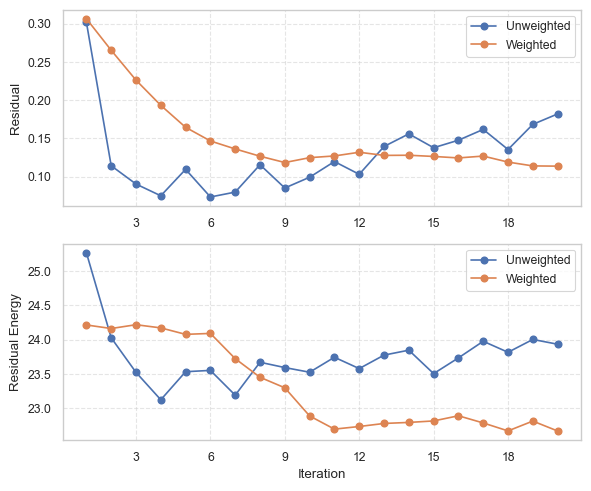

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# 1. 读取两个CSV文件
df_plain = pd.read_csv("./alignment_plain.csv")
df_weighted = pd.read_csv("./alignment_weighted.csv")

# 保证 iter 列是整数
df_plain["iter"] = df_plain["iter"].astype(int)
df_weighted["iter"] = df_weighted["iter"].astype(int)

plt.figure(figsize=(6,5), dpi=100)

# --- Residual ---
ax1 = plt.subplot(2, 1, 1)
ax1.plot(df_plain["iter"], df_plain["residual"], label="Unweighted", marker='o')
ax1.plot(df_weighted["iter"], df_weighted["residual"], label="Weighted", marker='o')
ax1.set_ylabel("Residual")
ax1.legend()
ax1.grid(linestyle='--', alpha=0.5)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# --- Energy ---
ax2 = plt.subplot(2, 1, 2)
ax2.plot(df_plain["iter"], df_plain["energy"], label="Unweighted", marker='o')
ax2.plot(df_weighted["iter"], df_weighted["energy"], label="Weighted", marker='o')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Residual Energy")
ax2.legend()
ax2.grid(linestyle='--', alpha=0.5)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


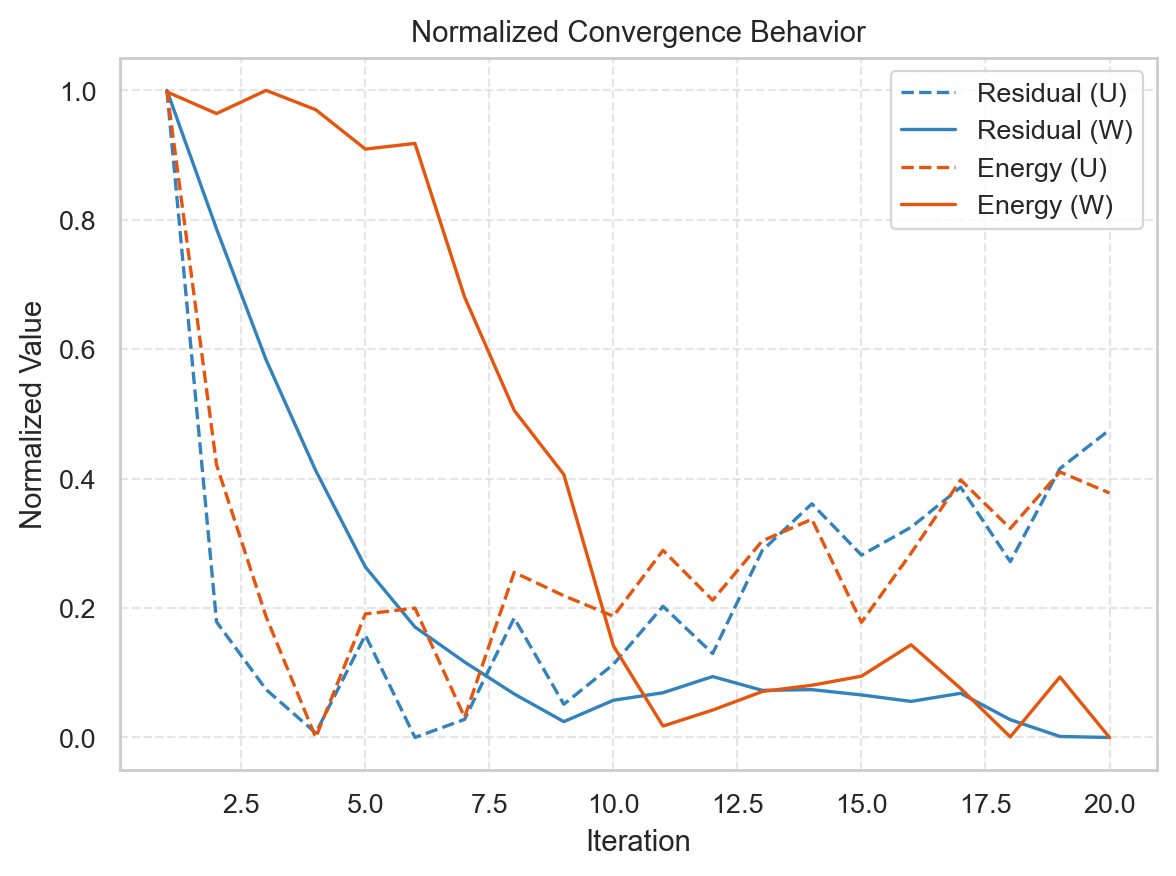

In [24]:
def normalize(x): return (x - np.min(x)) / (np.max(x) - np.min(x))

plt.figure(figsize=(6,4.5), dpi=200)
plt.plot(df_plain["iter"], normalize(df_plain["residual"]), '--', color="#3182bd", label="Residual (U)")
plt.plot(df_weighted["iter"], normalize(df_weighted["residual"]), '-', color="#3182bd", label="Residual (W)")
plt.plot(df_plain["iter"], normalize(df_plain["energy"]), '--', color="#e6550d", label="Energy (U)")
plt.plot(df_weighted["iter"], normalize(df_weighted["energy"]), '-', color="#e6550d", label="Energy (W)")
plt.xlabel("Iteration")
plt.ylabel("Normalized Value")
plt.title("Normalized Convergence Behavior")
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [7]:
# # === PDF export version of alignment convergence plot ===
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.ticker import MaxNLocator
# import matplotlib as mpl

# # --- Font and figure defaults for IEEE-style output ---
# mpl.rcParams.update({
#     "font.size": 8,
#     "axes.titlesize": 8,
#     "axes.labelsize": 8,
#     "xtick.labelsize": 7,
#     "ytick.labelsize": 7,
#     "legend.fontsize": 7,
#     "axes.linewidth": 0.6,
#     "grid.linewidth": 0.4,
#     "grid.alpha": 0.4,
#     "pdf.fonttype": 42,   # keep text as text, not outlines
#     "ps.fonttype": 42
# })

# # --- Load data ---
# df_plain = pd.read_csv("./alignment_plain.csv")
# df_weighted = pd.read_csv("./alignment_weighted.csv")

# df_plain["iter"] = df_plain["iter"].astype(int)
# df_weighted["iter"] = df_weighted["iter"].astype(int)

# # --- Create figure ---
# fig, (ax1, ax2) = plt.subplots(
#     2, 1, figsize=(3.4, 3.0), sharex=False
# )

# # --- Plot 1: Residual ---
# ax1.plot(df_plain["iter"], df_plain["residual"], label="Unweighted", marker='o', ms=3, lw=0.9)
# ax1.plot(df_weighted["iter"], df_weighted["residual"], label="Weighted", marker='o', ms=3, lw=0.9)
# ax1.set_ylabel("Residual")
# ax1.legend(frameon=False)
# ax1.grid(linestyle='--', alpha=0.4)
# ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# # --- Plot 2: Residual Energy ---
# ax2.plot(df_plain["iter"], df_plain["energy"], label="Unweighted", marker='o', ms=3, lw=0.9)
# ax2.plot(df_weighted["iter"], df_weighted["energy"], label="Weighted", marker='o', ms=3, lw=0.9)
# ax2.set_xlabel("Iteration")
# ax2.set_ylabel("Residual Energy")
# ax2.legend(frameon=False)
# ax2.grid(linestyle='--', alpha=0.4)
# ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

# plt.tight_layout(pad=0.5)
# plt.savefig("alignment_convergence.pdf", format="pdf", bbox_inches="tight")
# plt.show()


✅ Using subset of 50 curves for faster cross-validation.
Running fold 1/5
Running fold 2/5
Running fold 3/5
Running fold 4/5
Running fold 5/5


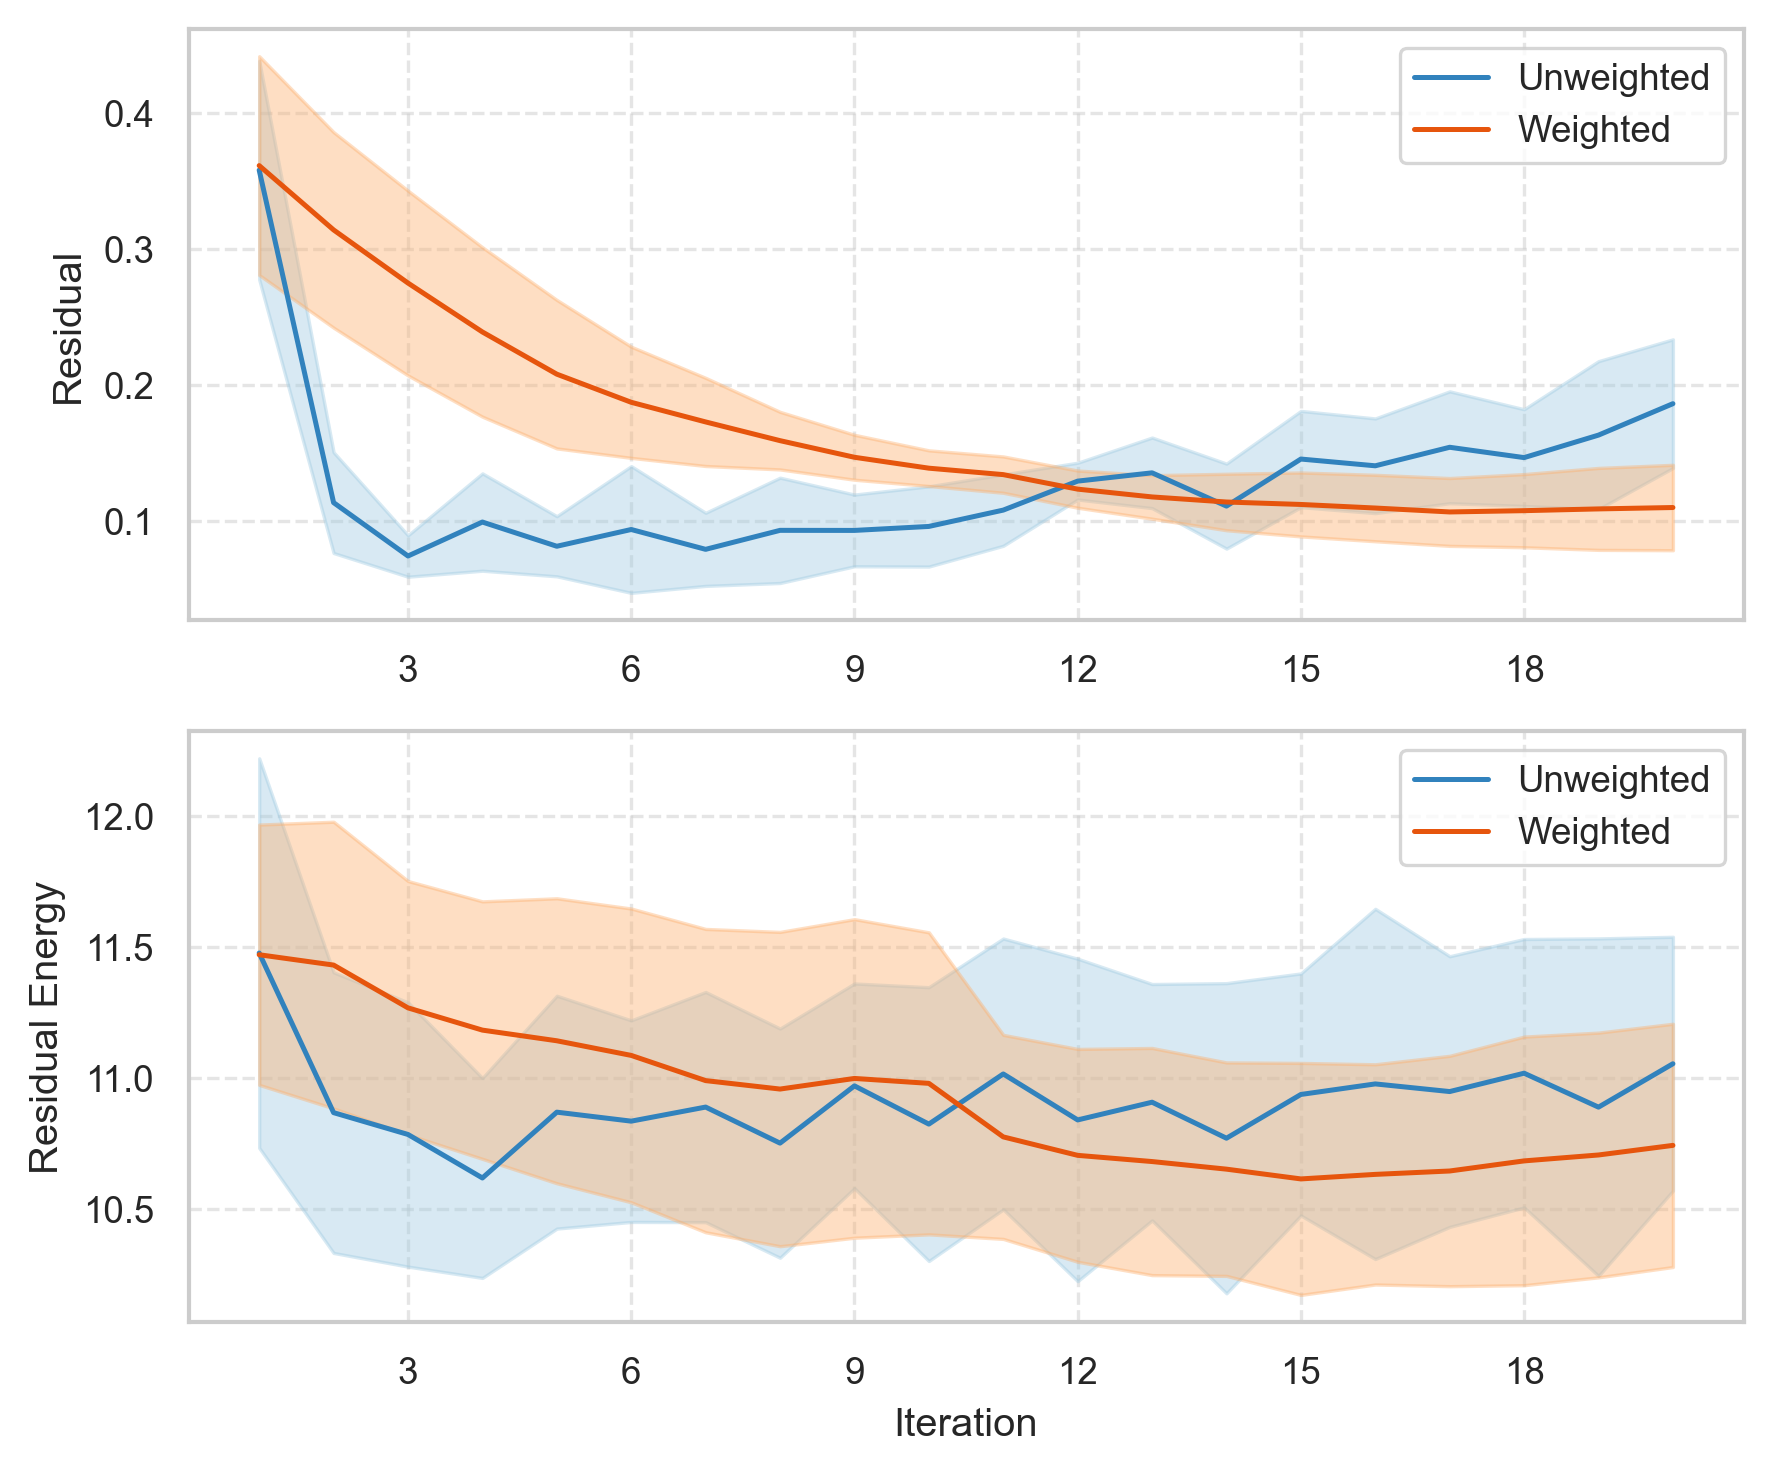

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import KFold
from scipy.integrate import trapezoid

# ========== 设置参数 ==========
MaxItr = 20
n_splits = 5
rng = np.random.default_rng(42)
fold_logs_plain = []
fold_logs_weighted = []
alpha_s = 0.75

# ========= 随机抽取 50 条曲线 =========
n_curves = f.shape[1]
subset_idx = rng.choice(n_curves, size=50, replace=False)
f = f[:, subset_idx]        # 只保留 50 条曲线
print(f"✅ Using subset of {f.shape[1]} curves for faster cross-validation.")

# ========== 多折运行 ==========
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold_idx, (train_idx, _) in enumerate(kf.split(f.T)):
    print(f"Running fold {fold_idx+1}/{n_splits}")
    f_train = f[:, train_idx]

    # ---- Plain alignment ----
    obj_plain_cv = fdawarp(f_train.copy(), time)
    with OutputCatcher() as c_plain:
        obj_plain_cv.srsf_align(parallel=False, MaxItr=MaxItr, verbose=True)
    plain_log = parse_alignment_log(c_plain.get())
    df_plain = pd.DataFrame(plain_log)
    fold_logs_plain.append(df_plain)

    # ---- Weighted alignment ----
    W_train = composite_weight(f_train, alpha_s=alpha_s)
    obj_weighted_cv = fdawarp(f_train.copy(), time)
    with OutputCatcher() as c_weighted:
        obj_weighted_cv.srsf_align_weighted(
            pointwise_weights=W_train,
            MaxItr=MaxItr,
            parallel=False,
            alpha=0.05,
            use_momentum=True,
            beta1=0.9,
            beta2=0.999,
            verbose=True
        )
    weighted_log = parse_alignment_log(c_weighted.get())
    df_weighted = pd.DataFrame(weighted_log)
    fold_logs_weighted.append(df_weighted)

# ========== 聚合统计 ==========
def aggregate_logs(logs, metric="energy"):
    # 对每个 fold 的不同长度进行对齐（截断到最短长度）
    min_len = min(len(df[metric]) for df in logs)
    mat = np.stack([df[metric].values[:min_len] for df in logs])
    mean = mat.mean(axis=0)
    std = mat.std(axis=0)
    return mean, std, np.arange(1, min_len + 1)

mean_E_plain, std_E_plain, iters = aggregate_logs(fold_logs_plain, "energy")
mean_E_weighted, std_E_weighted, _ = aggregate_logs(fold_logs_weighted, "energy")

mean_R_plain, std_R_plain, _ = aggregate_logs(fold_logs_plain, "residual")
mean_R_weighted, std_R_weighted, _ = aggregate_logs(fold_logs_weighted, "residual")

# ========== 绘图 ==========
plt.figure(figsize=(6,5), dpi=300)

# --- Residual ---
ax1 = plt.subplot(2, 1, 1)
ax1.plot(iters, mean_R_plain, label="Unweighted", color="#3182bd")
ax1.fill_between(iters,
                 mean_R_plain - std_R_plain,
                 mean_R_plain + std_R_plain,
                 color="#9ecae1", alpha=0.4)
ax1.plot(iters, mean_R_weighted, label="Weighted", color="#e6550d")
ax1.fill_between(iters,
                 mean_R_weighted - std_R_weighted,
                 mean_R_weighted + std_R_weighted,
                 color="#fdae6b", alpha=0.4)
ax1.set_ylabel("Residual")
ax1.legend()
ax1.grid(linestyle='--', alpha=0.5)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# --- Energy ---
ax2 = plt.subplot(2, 1, 2)
ax2.plot(iters, mean_E_plain, label="Unweighted", color="#3182bd")
ax2.fill_between(iters,
                 mean_E_plain - std_E_plain,
                 mean_E_plain + std_E_plain,
                 color="#9ecae1", alpha=0.4)
ax2.plot(iters, mean_E_weighted, label="Weighted", color="#e6550d")
ax2.fill_between(iters,
                 mean_E_weighted - std_E_weighted,
                 mean_E_weighted + std_E_weighted,
                 color="#fdae6b", alpha=0.4)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Residual Energy")
ax2.legend()
ax2.grid(linestyle='--', alpha=0.5)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


In [9]:
# === Quantitative summary for convergence behavior ===
import numpy as np
import pandas as pd

def summarize_convergence(mean_vals, std_vals, label="metric"):
    initial = mean_vals[0]
    final = mean_vals[-1]
    reduction = (initial - final) / initial if initial != 0 else np.nan
    area = np.trapz(mean_vals) / len(mean_vals)
    early_mean = mean_vals[:5].mean() if len(mean_vals) >= 5 else np.nan
    late_mean = mean_vals[-5:].mean() if len(mean_vals) >= 5 else np.nan
    early_drop = (early_mean - late_mean) / early_mean if early_mean != 0 else np.nan
    return {
        "metric": label,
        "initial": initial,
        "final": final,
        "reduction_ratio": reduction,
        "mean_area": area,
        "early_drop": early_drop,
        "std_final": std_vals[-1]
    }

summary = []
summary.append(summarize_convergence(mean_R_plain, std_R_plain, "Residual (Unweighted)"))
summary.append(summarize_convergence(mean_R_weighted, std_R_weighted, "Residual (Weighted)"))
summary.append(summarize_convergence(mean_E_plain, std_E_plain, "Energy (Unweighted)"))
summary.append(summarize_convergence(mean_E_weighted, std_E_weighted, "Energy (Weighted)"))

df_summary = pd.DataFrame(summary)
pd.options.display.float_format = '{:.6f}'.format
print("\n===== Quantitative Summary =====")
print(df_summary)

# --- Compute improvement ratios ---
def improvement(u, w):
    return (u - w) / u * 100 if u != 0 else np.nan

metrics = {
    "Final Residual Improvement (%)": improvement(
        df_summary.loc[0, "final"], df_summary.loc[1, "final"]),
    "Final Energy Improvement (%)": improvement(
        df_summary.loc[2, "final"], df_summary.loc[3, "final"]),
    "Reduction Ratio Improvement (%)": improvement(
        df_summary.loc[0, "reduction_ratio"], df_summary.loc[1, "reduction_ratio"]),
    "Energy Reduction Ratio Improvement (%)": improvement(
        df_summary.loc[2, "reduction_ratio"], df_summary.loc[3, "reduction_ratio"]),
}

print("\n===== Improvement Summary =====")
for k, v in metrics.items():
    print(f"{k}: {v:.2f}%")



===== Quantitative Summary =====
                  metric   initial     final  reduction_ratio  mean_area  \
0  Residual (Unweighted)  0.357826  0.186184         0.479680   0.116439   
1    Residual (Weighted)  0.361135  0.109877         0.695744   0.155464   
2    Energy (Unweighted) 11.476595 11.054823         0.036751  10.349584   
3      Energy (Weighted) 11.470241 10.743712         0.063340  10.362481   

   early_drop  std_final  
0   -0.088615   0.047268  
1    0.611606   0.031377  
2   -0.004935   0.483728  
3    0.054506   0.463435  

===== Improvement Summary =====
Final Residual Improvement (%): 40.98%
Final Energy Improvement (%): 2.81%
Reduction Ratio Improvement (%): -45.04%
Energy Reduction Ratio Improvement (%): -72.35%


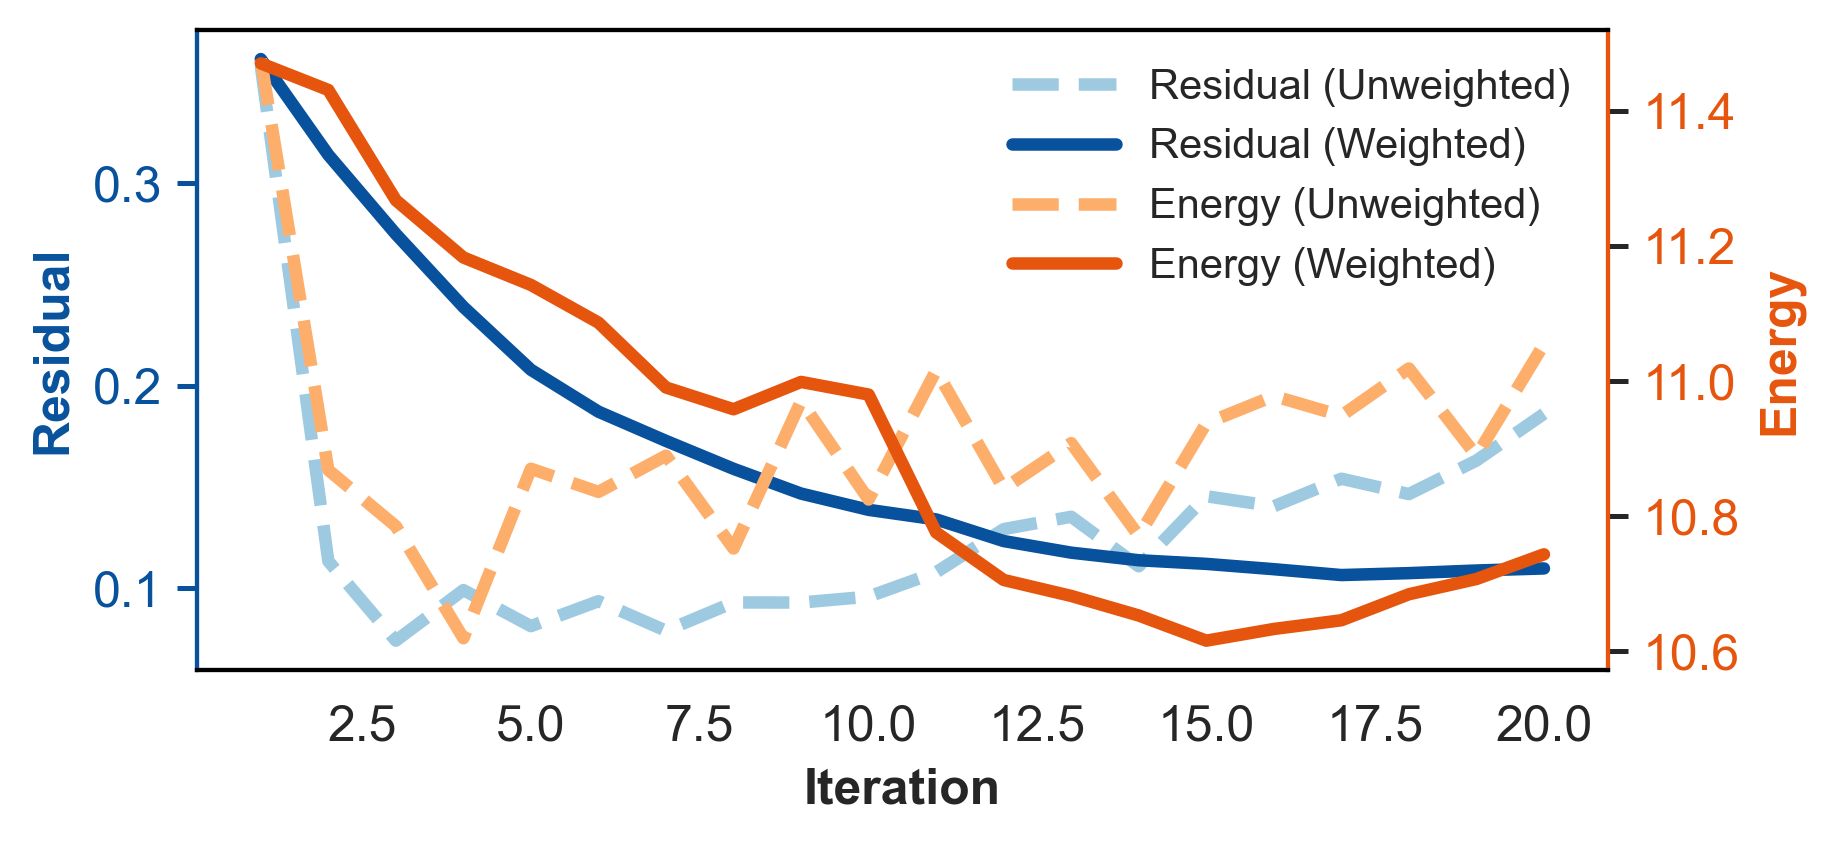

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# ===== 全局样式设置 =====
sns.set_style("whitegrid", {'axes.edgecolor': 'black'})
sns.set_palette("deep")

plt.rcParams.update({
    "font.size": 13,             # 全局字体
    "axes.titlesize": 12,        # 标题字体
    "axes.labelsize": 13,        # 坐标轴标题字体
    "xtick.labelsize": 12,       # x轴刻度字体
    "ytick.labelsize": 12,       # y轴刻度字体
    "legend.fontsize": 13,       # 图例字体
    "font.family": "sans-serif", # 无衬线字体 (IEEE 推荐)
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"]
})

# ===== 绘图 =====
fig, ax1 = plt.subplots(figsize=(6.3, 3.0), dpi=300)  # 稍加宽一点

# --- Residual (蓝色系) ---
ax1.plot(iters, mean_R_plain, color="#9ecae1", label="Residual (Unweighted)", linestyle="--", linewidth=3.0)
ax1.plot(iters, mean_R_weighted, color="#08519c", label="Residual (Weighted)", linewidth=3.0)
ax1.set_xlabel("Iteration", fontsize=12, fontweight="bold")
ax1.set_ylabel("Residual", color="#08519c", fontsize=12, fontweight="bold")
ax1.tick_params(axis='y', labelcolor="#08519c", colors="#08519c", width=1.2)
ax1.spines["right"].set_color("#e6550d")
ax1.spines["left"].set_color("#08519c")

# --- Energy (橙色系) ---
ax2 = ax1.twinx()
ax2.plot(iters, mean_E_plain, color="#fdae6b", label="Energy (Unweighted)", linestyle="--", linewidth=3.0)
ax2.plot(iters, mean_E_weighted, color="#e6550d", label="Energy (Weighted)", linewidth=3.0)
ax2.set_ylabel("Energy", color="#e6550d", fontsize=12, fontweight="bold")
ax2.tick_params(axis='y', labelcolor="#e6550d", width=1.2)
ax2.spines["right"].set_color("#e6550d")
ax2.spines["left"].set_color("#08519c")

# --- Legend ---
lns = ax1.lines + ax2.lines
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="upper right", frameon=False, fontsize=10, ncol=1, handlelength=2.5)

# --- Grid & layout ---
ax1.grid(False)
ax2.grid(False)
plt.tight_layout()

# ===== 导出为 PDF =====
plt.savefig("alignment_convergence_combined.pdf",
            bbox_inches="tight", transparent=True, dpi=600)
plt.show()


In [46]:
import numpy as np
import pandas as pd

# --- 安全检查（可选） ---
required = [
    "iters",
    "mean_R_plain", "std_R_plain",
    "mean_R_weighted", "std_R_weighted",
    "mean_E_plain", "std_E_plain",
    "mean_E_weighted", "std_E_weighted",
]
missing = [v for v in required if v not in globals()]
if missing:
    raise NameError(f"Missing variables: {missing}")

# === 宽表：每列是一条曲线（含std） ===
df_wide = pd.DataFrame({
    "iter": np.asarray(iters, dtype=int),
    "Residual_Unweighted_mean": np.asarray(mean_R_plain),
    "Residual_Unweighted_std":  np.asarray(std_R_plain),
    "Residual_Weighted_mean":   np.asarray(mean_R_weighted),
    "Residual_Weighted_std":    np.asarray(std_R_weighted),
    "Energy_Unweighted_mean":   np.asarray(mean_E_plain),
    "Energy_Unweighted_std":    np.asarray(std_E_plain),
    "Energy_Weighted_mean":     np.asarray(mean_E_weighted),
    "Energy_Weighted_std":      np.asarray(std_E_weighted),
})

# 衍生列（可选）：同迭代步的“加权-未加权”差值
df_wide["Residual_delta_weighted_minus_unweighted"] = (
    df_wide["Residual_Weighted_mean"] - df_wide["Residual_Unweighted_mean"]
)
df_wide["Energy_delta_weighted_minus_unweighted"] = (
    df_wide["Energy_Weighted_mean"] - df_wide["Energy_Unweighted_mean"]
)

# === 长表：便于后续统计与可视化（metric / scheme 两个维度） ===
def to_long(df):
    rows = []
    for i, it in enumerate(df["iter"]):
        rows += [
            {"iter": it, "metric": "Residual", "scheme": "Unweighted",
             "mean": df["Residual_Unweighted_mean"][i], "std": df["Residual_Unweighted_std"][i]},
            {"iter": it, "metric": "Residual", "scheme": "Weighted",
             "mean": df["Residual_Weighted_mean"][i], "std": df["Residual_Weighted_std"][i]},
            {"iter": it, "metric": "Energy", "scheme": "Unweighted",
             "mean": df["Energy_Unweighted_mean"][i], "std": df["Energy_Unweighted_std"][i]},
            {"iter": it, "metric": "Energy", "scheme": "Weighted",
             "mean": df["Energy_Weighted_mean"][i], "std": df["Energy_Weighted_std"][i]},
        ]
    return pd.DataFrame(rows)

df_long = to_long(df_wide)

# === 保存到 CSV（路径可自行修改） ===
df_wide.to_csv("convergence_points_wide.csv", index=False)
df_long.to_csv("convergence_points_long.csv", index=False)

# === 预览 ===
print("Wide format (head):")
print(df_wide.head())
print("\nLong format (head):")
print(df_long.head())
print("\nSaved: convergence_points_wide.csv, convergence_points_long.csv")


Wide format (head):
   iter  Residual_Unweighted_mean  Residual_Unweighted_std  \
0     1                  0.357826                 0.080323   
1     2                  0.113484                 0.037029   
2     3                  0.074251                 0.015213   
3     4                  0.099204                 0.035767   
4     5                  0.081413                 0.022092   

   Residual_Weighted_mean  Residual_Weighted_std  Energy_Unweighted_mean  \
0                0.361135               0.080374               11.476595   
1                0.313883               0.071850               10.868489   
2                0.274824               0.067894               10.785339   
3                0.238878               0.062251               10.619557   
4                0.207874               0.054563               10.870340   

   Energy_Unweighted_std  Energy_Weighted_mean  Energy_Weighted_std  \
0               0.742169             11.470241             0.495975   
1       